In [1]:
import vaex as vx
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from datetime import datetime
from dateutil import parser
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import ParameterGrid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib widget
%load_ext line_profiler

In [2]:
path = os.getcwd()

In [5]:
# Specifying all dtypes to maximize  efficiency
dtypes = {'Service Transaction ID':'string',
 'Sale ID':'string',
 'Sale Date':'string',
 'Sale Item ID':'string',
 'Sale Facility Country':'string',
 'Sale Day':'string',
 'Sale Facility':'string',
 'Sale Facility ID':'string',
 'Mph Arma ID':'string',
 'Customer Type':'string',
 'Vdl Drug ID':'string',
 'Vdl Drug Display Name':'string',
 'Unit Selling Price Local':'float32',
 'Unit Selling Price Usd':'float32',
 'Quantity In Units':'float32',
 'Quantity In Packs':'float32',
 'Sale Item Selling Price Local':'float32',
 'Sale Item Selling Price Usd':'float32',
 'Unit Vm I Cost Price Local':'float32',
 'Sale Item Vm I Cost Price Local':'float32',
 'Sale Item Vm I Cost Price Usd':'float32',
 'Sale Item Vm I Margin Local':'float32',
 'Sale Item Vm I Margin Usd':'float32',
 'Unit Cost Price Local':'float32',
 'Unit Cost Price Usd':'float32',
 'Sale Item Cost Price Local':'float32',
 'Sale Item Cost Price Usd':'float32',
 'Sale Item Margin Local':'float32',
 'Sale Item Margin Usd':'float32',
 'Payment Method Type':'string',
 'Payment Timing Type':'string',
 'Product ID':'string',
 'Product Name':'string',
 'Product Alias ID':'string',
 'Product Alias Name':'string',
 'Patient Facility ID':'string',
 'Patient Facility Name':'string',
 'Patient Risk Tier Type':'string',
 'Corporate Facility Name':'string',
 'Customer Corporate Type':'string',
 'Facility Country':'string',
 'Sale Date Local':'string',
 'Item Category':'string',
 'Item Sub Category':'string',
 'Insurance Pay Or':'string',
 'Product Source':'string',
 'Vat Local (for The It Em)':'float32',
 'Vat Usd (for The It Em)':'float32',
 'Is Manual':'string',
 'Receipt ID':'string',
 'How Its Sold':'string',
 'Is Off Formula Ry':'string',
 'Mv Drug Abc → Country':'string',
 'Mv Drug Abc → Class':'string',
 'Mv Drug Abc → Class By Value':'string',
 'Mv Drug Abc → Class By Quantity':'string',
 'Mv Drug Abc → Class By Transaction Count':'string',
 'Mv Drug Abc → Class By Margin':'string'}
parse_dates = ['Sale Date', 'Sale Day', 'Sale Date Local']


#custom_dates = lambda x: parser.parse(x) or pd.to_datetime
#You can try both to check speed of import


In [6]:
# Imports data

try:
    data = vx.open('%s//Data//consumption_data.csv.hdf5'%path)
except (FileNotFoundError):
    data = vx.from_csv('%s//Data//consumption_data.csv'%path, 
                       dtype=dtypes, parse_dates=parse_dates, date_parser=pd.to_datetime,
            chunk_size=100_000, convert=True)

In [14]:
data['Quantity In Units'].values

array([ 1.,  1.,  2., ...,  1., 30., 30.], dtype=float32)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
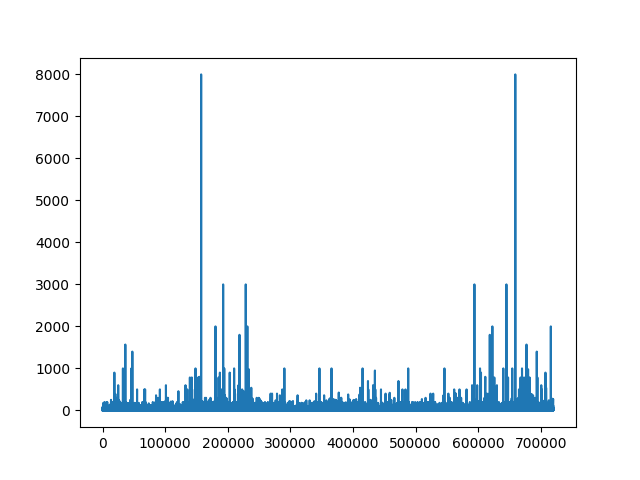

Wall time: 784 ms


In [42]:
%%time
plt.plot(data['Quantity In Units'].to_numpy())
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
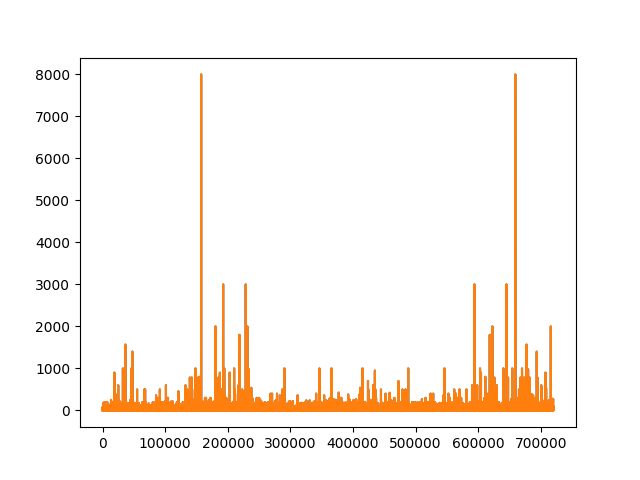

Wall time: 205 ms


In [4]:
%%time
plt.plot(data['Quantity In Units'].values)
plt.show()

In [15]:
# Viewing Data
display(data.head())
display(data.tail())

#,Service Transaction ID,Sale ID,Sale Date,Sale Item ID,Sale Facility Country,Sale Day,Sale Facility,Sale Facility ID,Mph Arma ID,Customer Type,Vdl Drug ID,Vdl Drug Display Name,Unit Selling Price Local,Unit Selling Price Usd,Quantity In Units,Quantity In Packs,Sale Item Selling Price Local,Sale Item Selling Price Usd,Unit Vm I Cost Price Local,Sale Item Vm I Cost Price Local,Sale Item Vm I Cost Price Usd,Sale Item Vm I Margin Local,Sale Item Vm I Margin Usd,Unit Cost Price Local,Unit Cost Price Usd,Sale Item Cost Price Local,Sale Item Cost Price Usd,Sale Item Margin Local,Sale Item Margin Usd,Payment Method Type,Payment Timing Type,Product ID,Product Name,Product Alias ID,Product Alias Name,Patient Facility ID,Patient Facility Name,Patient Risk Tier Type,Corporate Facility Name,Customer Corporate Type,Facility Country,Sale Date Local,Item Category,Item Sub Category,Insurance Pay Or,Product Source,Vat Local (for The It Em),Vat Usd (for The It Em),Is Manual,Receipt ID,How Its Sold,Is Off Formula Ry,Mv Drug Abc → Country,Mv Drug Abc → Class,Mv Drug Abc → Class By Value,Mv Drug Abc → Class By Quantity,Mv Drug Abc → Class By Transaction Count,Mv Drug Abc → Class By Margin
0,91448,53b21d1b-5f91-4498-81cc-c5c78e5296b8,2020-02-22 20:39:03.550000000,10634,Ghana,2020-02-22 00:00:00.000000000,3A HEALTH,5e4a8e5ded73cf0076d21dfc,3670829,guest,165693,LONART DS x1,15.93,2.99195,1,1,15.93,2.99195,0,0,0,15.93,2.99195,0,0,0,0,15.93,2.99195,Cash,Time of Sale,d3d12db6-c8ac-4bad-9275-0df1bf542501,LONART DS x1,eeddbfa9-c5c5-4e07-bcc8-73b75a8567b7,LONART DS x1,5e4a8e5ded73cf0076d21dfc,3A HEALTH,No Policy,--,guest,Ghana,2020-02-22 20:39:03.550000000,DRUGS,Anti-Infectives,None,formulary,0,0,false,1DFC-0000000001,TABLET,false,Ghana,A,A,B,A,A
1,91466,456beab8-433b-43f1-ba0c-0b9a3c62ca45,2020-02-22 13:07:50.726000000,10647,Ghana,2020-02-22 00:00:00.000000000,Narteva Pharmacy,5e4a8caded73cf0076d21df4,9616396,member,228432,LOFNAC 100MG TAB 10'S x20,1.25,0.234773,1,0.05,1.25,0.234773,0,0,0,1.25,0.234773,0,0,0,0,1.25,0.234773,Cash,Time of Sale,09e94d4e-d77e-4b03-8f18-23e7df323d7e,LOFNAC 100MG TAB 10'S x20,e87b0b20-dcd5-4ba7-84df-b55895d96b4f,LOFNAC 100MG TAB 10'S x20,5e4a8caded73cf0076d21df4,Narteva Pharmacy,No Policy,--,non-corporate member,Ghana,2020-02-22 13:07:50.726000000,DRUGS,Analgesics,None,formulary,0,0,false,1DF4-0000000011,TABLET,false,Ghana,A,B,B,A,B
2,91494,8b87d8fa-12d6-43c2-93ad-5fecc1edb1f6,2020-02-22 21:48:41.710000000,10662,Ghana,2020-02-22 00:00:00.000000000,3A HEALTH,5e4a8e5ded73cf0076d21dfc,3670829,guest,165649,FERROUS SULPHATE x28 UK,0.39,0.0732493,2,0.0714286,0.78,0.146499,0,0,0,0.78,0.146499,0,0,0,0,0.78,0.146499,Cash,Time of Sale,86bfb6d9-89b2-48a3-8ccd-db0835ab1c94,FERROUS SULPHATE x28 UK,3aa1c70f-3bf9-4fd2-a5e2-b3a5ea1c084c,FERROUS SULPHATE x28 UK,5e4a8e5ded73cf0076d21dfc,3A HEALTH,No Policy,--,guest,Ghana,2020-02-22 21:48:41.710000000,DRUGS,Supplements,None,formulary,0,0,false,1DFC-0000000019,TABLET,false,--,--,--,--,--,--
3,91507,9a27e282-45f6-40ef-8662-29c2f689e07c,2020-02-22 22:05:22.955000000,10667,Ghana,2020-02-22 00:00:00.000000000,3A HEALTH,5e4a8e5ded73cf0076d21dfc,3670829,guest,169837,CITRO-C 100MG x25,1.66,0.311779,2,0.08,3.32,0.623558,0,0,0,3.32,0.623558,0,0,0,0,3.32,0.623558,Cash,Time of Sale,b0337df8-f7fb-4ef4-83d9-8e087933ab4e,CITRO-C 100MG x25,8f5adcea-420b-49fb-a22f-b76b3802cbbf,CITRO-C 100MG x25,5e4a8e5ded73cf0076d21dfc,3A HEALTH,No Policy,--,guest,Ghana,2020-02-22 22:05:22.955000000,DRUGS,Supplements,None,formulary,0,0,false,1DFC-0000000022,TABLET,false,Ghana,A,A,B,A,B
4,91567,fd0be28a-8748-46fa-8765-669dbf127076,2020-02-22 15:14:34.437000000,10705,Ghana,2020-02-22 00:00:00.000000000,Narteva Pharmacy,5e4a8caded73cf0076d21df4,2051523,member,234450,MULTIVITAMIN TABS BLISTER 10'S x50,0.22,0.0413201,30,0.6,6.6,1.2396,0,0,0,6.6,1.2396,0,0,0,0,6.6,1.2396,Cash,Time of Sale,0b6cd367-9015-49b4-8cdf-e8b5234d3183,MULTIVITAMIN TABS BLISTER 10'S x50,8eee24aa-399f-4a03-9e6f-beb4633c248f,MULTIVITAMIN TABS BLISTER 10'S x50,5e4a8

#,Service Transaction ID,Sale ID,Sale Date,Sale Item ID,Sale Facility Country,Sale Day,Sale Facility,Sale Facility ID,Mph Arma ID,Customer Type,Vdl Drug ID,Vdl Drug Display Name,Unit Selling Price Local,Unit Selling Price Usd,Quantity In Units,Quantity In Packs,Sale Item Selling Price Local,Sale Item Selling Price Usd,Unit Vm I Cost Price Local,Sale Item Vm I Cost Price Local,Sale Item Vm I Cost Price Usd,Sale Item Vm I Margin Local,Sale Item Vm I Margin Usd,Unit Cost Price Local,Unit Cost Price Usd,Sale Item Cost Price Local,Sale Item Cost Price Usd,Sale Item Margin Local,Sale Item Margin Usd,Payment Method Type,Payment Timing Type,Product ID,Product Name,Product Alias ID,Product Alias Name,Patient Facility ID,Patient Facility Name,Patient Risk Tier Type,Corporate Facility Name,Customer Corporate Type,Facility Country,Sale Date Local,Item Category,Item Sub Category,Insurance Pay Or,Product Source,Vat Local (for The It Em),Vat Usd (for The It Em),Is Manual,Receipt ID,How Its Sold,Is Off Formula Ry,Mv Drug Abc → Country,Mv Drug Abc → Class,Mv Drug Abc → Class By Value,Mv Drug Abc → Class By Quantity,Mv Drug Abc → Class By Transaction Count,Mv Drug Abc → Class By Margin
0,45535,--,2019-11-06 17:32:35.313533000,--,Ghana,2019-11-06 00:00:00.000000000,UNIHAM PHARMACY,5d8cce4690ef88007614bc6b,3994399,guest,236865,NOVAGYL 400MG TABS x500,0.14,0.0260223,20,0.04,2.8,0.520446,0,0,0,2.8,0.520446,0.1,0.0185874,2,0.371747,0.8,0.148699,Cash,Time of Sale,5d0777329e3128006712c892,NOVAGYL 400MG TABS,--,--,5d8cce4690ef88007614bc6b,UNIHAM PHARMACY,No Policy,--,guest,Ghana,2019-11-06 17:32:35.313533000,DRUGS,Anti-Infectives,None,formulary,0,0,false,--,--,--,Ghana,C,C,C,C,C
1,11424,--,2019-07-05 18:13:27.063593000,--,Ghana,2019-07-05 00:00:00.000000000,Fresh Spring Chemists Ltd,5b926cfa9e312800268639f8,7108806,guest,225104,DOLOPLUS TAB 10'S x1,1.32,0.25097,1,1,1.32,0.25097,0,0,0,1.32,0.25097,0.98,0.186326,0.98,0.186326,0.34,0.0646437,Cash,Time of Sale,5cb5ea0890ef880071ade11f,DOLOPLUS TAB 10'S,--,--,5b926cfa9e312800268639f8,Fresh Spring Chemists Ltd,No Policy,--,guest,Ghana,2019-07-05 18:13:27.063593000,DRUGS,Analgesics,None,formulary,0,0,false,--,--,--,Ghana,C,C,C,C,C
2,31234,--,2019-09-26 13:49:26.034080000,--,Ghana,2019-09-26 00:00:00.000000000,Emboch Chemist,5bc5d7149e31280026863a40,9914023,member,237784,CHOCHO TEA 85G x1,6.86,1.29314,1,1,6.86,1.29314,0,0,0,6.86,1.29314,5.72,1.07825,5.72,1.07825,1.14,0.214896,Cash,Time of Sale,5d1600be9e3128006712c95c,CHOCHO TEA 85G,--,--,5bc5d7149e31280026863a40,Emboch Chemist,Policy 3,--,non-corporate member,Ghana,2019-09-26 13:49:26.034080000,DRUGS,herbals,None,formulary,0,0,false,--,--,--,Ghana,C,C,C,C,C
3,71952,--,2020-01-07 14:09:58.071529000,--,Ghana,2020-01-07 00:00:00.000000000,Fresh Spring Chemists Ltd,5b926cfa9e312800268639f8,7108806,guest,240472,ENACIN-C 300MG CAPS x100,1.03,0.187399,20,0.2,20.6,3.74799,0,0,0,20.6,3.74799,0.76,0.138275,15.2,2.76551,5.4,0.982482,Cash,Time of Sale,5d386ed141aa1300710a3bf9,ENACIN-C 300MG CAPS,--,--,5b926cfa9e312800268639f8,Fresh Spring Chemists Ltd,No Policy,--,guest,Ghana,2020-01-07 14:09:58.071529000,DRUGS,Anti-Infectives,None,formulary,0,0,false,--,--,--,Ghana,B,B,B,B,B
4,63375,--,2019-12-17 18:12:48.412751000,--,Ghana,2019-12-17 00:00:00.000000000,Emboch Chemist,5bc5d7149e31280026863a40,1898725,guest,241043,DETTOL ANTISEPTIC 250ML x1,17.28,3.2119,1,1,17.28,3.2119,0,0,0,17.28,3.2119,12.8,2.37918,12.8,2.37918,4.48,0.832714,Cash,Time of Sale,5d42cfc141aa1300710a3cda,DETTOL ANTISEPTIC 250ML,--,--,5bc5d7149e31280026863a40,Emboch Chemist,No Policy,--,guest,Ghana,2019-12-17 18:12:48.412751000,DRUGS,Consumables,None,formulary,0,0,false,--,--,--,Ghana,C,C,C,C,C
5,50065,--,2019-11-17 13:40:09.826139000,--,Ghana,2019-11-17 00:00:00.000000000,CENTRIXMAS PHARMACY,5d8cd60090ef88007614bc73,6883562,guest,228432,LOFNAC 100MG TAB 10'S x20,1.35,0.250929,1,0.05,1.35,0.250929,0,0,0,1.35,0.250929,1,0.185874,1,0.185874,0.35,0.0650558,Cash,Time of Sale,5cdab8a8d03b4f0070b3b68b,LOFNAC 100

In [16]:
# Place all Column Names in a List
col_names = data.get_column_names()
# Renaming all columns to fit Vaex standards
for i in col_names:
    data.rename(i,i.replace(" ", "_"))
    data.rename(i, i.replace("-","_"))


In [17]:
col_names = data.get_column_names()

# Filtering Data to relevant Columns
df = data.copy()[[col_names[2], col_names[4], col_names[5], col_names[6], 
                col_names[9], col_names[10], col_names[11], col_names[12], col_names[13],
                col_names[14], col_names[15],col_names[41], col_names[43], col_names[44], col_names[50]]]

In [18]:
# Viewing the Relevant Columns
df.get_column_names()
# Sort Time Series
df = df.sort(by='Sale_Date', ascending=True)

In [41]:
df.Sale_Date.values

array(['2010-12-05T23:12:11.748000000', '2010-12-05T23:12:11.748000000',
       '2010-12-05T23:16:20.345000000', ...,
       '2021-10-08T16:51:14.390000000', '2021-10-08T16:51:52.011000000',
       '2021-10-08T16:55:04.269000000'], dtype='datetime64[ns]')

In [19]:
indications = dict(df.groupby('Item_Sub_Category'))
anti_d = indications[('Anti-Diabetics',)]
anti_d = vx.from_arrays(x=anti_d['Sale_Date'].values,y=anti_d['Quantity_In_Units'].values)
anti_d.rename("x", "Sale_Date")
anti_d.rename("y", "Quantity_In_Units")

'Quantity_In_Units'

In [119]:
gp = df.groupby(by=vx.BinnerTime(df['Sale_Date'], resolution='D'), agg={'Quantity_In_Units':'sum'})
gp

#,Sale_Date,Quantity_In_Units
0,2010-12-05,26.0
1,2010-12-06,2.0
2,2018-05-28,260.0
3,2018-05-31,120.0
4,2018-06-27,120.0
...,...,...
"1,069",2021-10-04,9069.0
"1,070",2021-10-05,6870.0
"1,071",2021-10-06,6317.0
"1,072",2021-10-07,8795.0


In [105]:
df.index = pd.to_datetime(df['Sale_Date'].values, unit='s')

In [107]:
df.index

DatetimeIndex(['2010-12-05 23:12:11.748000', '2010-12-05 23:12:11.748000',
               '2010-12-05 23:16:20.345000', '2010-12-05 23:19:05.819000',
               '2010-12-05 23:25:40.730000', '2010-12-05 23:25:40.730000',
               '2010-12-06 00:18:28.622000', '2010-12-06 00:20:07.134000',
               '2018-05-28 11:59:55.485640', '2018-05-28 11:59:55.485640',
               ...
               '2021-10-08 16:43:40.423000', '2021-10-08 16:43:40.423000',
               '2021-10-08 16:46:27.430000', '2021-10-08 16:46:27.430000',
               '2021-10-08 16:47:29.460000', '2021-10-08 16:49:24.136000',
               '2021-10-08 16:51:14.390000', '2021-10-08 16:51:14.390000',
               '2021-10-08 16:51:52.011000', '2021-10-08 16:55:04.269000'],
              dtype='datetime64[ns]', length=720155, freq=None)

In [ ]:
pd.to_datetime(df['Sale_Date'][0)

In [94]:
df['Sale_Date'].values[0]

numpy.datetime64('2010-12-05T23:12:11.748000000')

In [88]:
wk.groupby(by=['Sale_Facility', 'Item_Sub_Category','Customer_Type',vx.BinnerTime(wk['Sale_Date'], resolution='W')],
               agg={'Quantity_In_Units':'sum'})

ArrowNotImplementedError: Unsupported datetime64 time unit

In [36]:
weekly = anti_d.groupby(by=vx.BinnerTime(anti_d['Sale_Date'], resolution='W'), agg={'count':'count'})
daily = anti_d.groupby(by=vx.BinnerTime(anti_d['Sale_Date'], resolution='D'), agg={'count':'count'})
monthly = anti_d.groupby(by=vx.BinnerTime(anti_d['Sale_Date'], resolution='M'), agg={'count':'count'})

In [130]:
for i in df['Item_Sub_Category'].unique():
    item_mask = df['Item_Sub_Category'] == i
    item_data = df[item_mask]
    weekly = item_data.groupby(by=vx.BinnerTime(item_df['Sale_Date'], resolution='W', agg={'Quantity_In_Units':'sum'}))
    

NotImplementedError: 

In [134]:
weekly = item_data.groupby(by=vx.BinnerTime(item_data['Sale_Date'], resolution='W'), agg={'Quantity_In_Units':'sum'})


In [135]:
len(weekly)

#,Sale_Date,Quantity_In_Units
0,2018-10-18,1.0
1,2018-11-01,3.0
2,2018-11-08,2.0
3,2018-11-15,2.0
4,2018-11-29,3.0
...,...,...
148,2021-09-09,23.0
149,2021-09-16,56.0
150,2021-09-23,39.0
151,2021-09-30,35.0


In [ ]:
dates = {}

for i in df

In [37]:
def rolling_window(a, window, find_mean, find_std):
    old_shape = a.shape[0]
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    view = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    
    if find_mean:
        final = np.array([view[i,:].mean() for i in range(view.shape[0])])
        
    elif find_std:
        final = np.array([view[i,:].std() for i in range(view.shape[0])])
        
    new_shape = view.shape[0]
    zeros = np.array([0 for x in range(old_shape - new_shape)])
    result = np.concatenate((zeros,final))
    return result

In [38]:
def plots(x, y, title, date="%b, %d %Y", window=3, xlabel='Date', ylabel='Quantity of Anti_Diabetic Sold in Units', mean=False, std=False, sav=False):
    fig = plt.figure()
    plt.plot_date(x, y, linestyle='solid', marker=None, fmt='g', label='Main Time Series Data')
    if sav:
        plt.plot_date(x, savgol_filter(y,window,3),
                      linestyle='solid', marker=None, fmt='y', label='Saviztky Golay Algo with Window Size of %s'%window)
    if mean:
        plt.plot_date(x, rolling_window(y,window=window,find_mean=True,find_std=False),
                      linestyle='solid', marker=None, fmt='r', label='Moving Average with Window Size of %s'%window)
    if std:
        plt.plot_date(x, rolling_window(y,window=window,find_std=True, find_mean=False),
                      linestyle='solid', marker=None, fmt='b', label='Moving Std with Window Size of %s'%window)
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter(date)
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
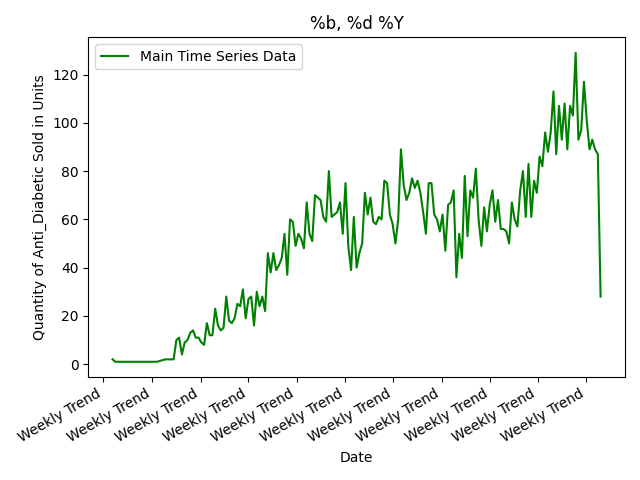

In [39]:
plots(weekly['Sale_Date'].values, weekly['count'].values, "%b, %d %Y", 'Weekly Trend', 5)

In [ ]:
plots(daily['Sale_Date'].values, daily['count'].values, "%b, %d %Y", 'Daily Trend',  5)

In [ ]:
plots(monthly['Sale_Date'].values, monthly['count'].values, "%b, %d %Y", 'Monthly Trend', 5)

In [ ]:
plots(anti_d.sort(by='Sale_Date')['Sale_Date'].values, anti_d.sort(by='Sale_Date')['Quantity_In_Units'].values, "%b, %d %Y", 'Monthly Trend', 5)

In [ ]:
# Adfuller Test to Check for Stationary Datasets
def stat_check(data, ts):
    test = adfuller(data, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic', 'P-value', '#lags used', 'Number of Observations Used'])
    for key,value in test[4].items():
        results['Critical Value (%s)'%key] = value
    
    print(f'Results of Dickey Fuller Test for {ts} Data \n{results}')


stat_check(weekly['count'].values, "Weekly")
stat_check(monthly['count'].values, "Monthly")
stat_check(daily['count'].values, "Daily")
stat_check(anti_d['Quantity_In_Units'].values, "Hourly")


In [ ]:
# One means of ensuring stationarity is decomposing and taking the residuals
result = seasonal_decompose(monthly['count'].values, period=12)

In [ ]:
plots(monthly['Sale_Date'].values, result.trend, 'Trend')
plots(monthly['Sale_Date'].values, result.seasonal, 'Seasonality')
plots(monthly['Sale_Date'].values, result.resid, 'Residuals')

In [ ]:
monthly = vx.from_arrays(x=monthly["Sale_Date"].values, y=monthly["count"].values)
monthly.rename("x","Sale_Date")
monthly.rename("y","count")

In [ ]:
# Transforming data to ensure stationarity (Log/MA)
monthly['log_data'] = monthly['count'].apply(lambda x: np.log(x))

In [ ]:
monthly.head()

In [ ]:
log_ma = rolling_window(monthly['log_data'].values, 12, find_mean=True, find_std=False)

In [ ]:
plots(monthly['Sale_Date'].values, monthly['log_data'].values, 'Monthly Trend', mean=True, window=12)
stat_check(anti_d['log_data'].values, "Monthly")
# plots(monthly['Sale_Date'].values, rolling_window(monthly['log_data'].values, 12,
#                                                  find_mean=True, find_std=False), "%b, %d %Y", 'Monthly Trend', 5)
stat_check(log_ma, "Mean Log")

In [ ]:
# Differencing
def diff(dataset, interval, col):
    result = []
    for i in range(interval, len(dataset)):
        offset = i - interval
        value = dataset[col].values[i] - dataset[col].values[offset]
        result.append(value)
    return (result)

%lprun -f diff diff(dataset=anti_d, interval=1, col="log_data")

In [ ]:
jot = monthly.diff(column="log_data", fill_value="nan")

In [ ]:
monthly.diff(column="log_data", fill_value="nan")

In [ ]:
monthly["diff"] = jot["log_data"].values

In [ ]:
stat_check(anti_d["log_diff"].values)

In [ ]:
# Determing p and q
lag_acf = acf(anti_d["Quantity_In_Units"].values, nlags=20)
lag_pacf = pacf(anti_d["Quantity_In_Units"].values, nlags=20)

In [ ]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()  
  return

In [ ]:
plot_acf_pacf(anti_d["Quantity_In_Units"].values, "Data")

In [ ]:
fig,(ax1,ax2)= plt.subplots(1, 2)
ax1 = plot_acf(anti_d["Quantity_In_Units"].values, lags=40, ax=ax1)
ax2 = plot_pacf(anti_d["Quantity_In_Units"].values, lags=40, ax=ax2)

In [ ]:
def run_arima_model(df, dates, p, d, q):
  """
  Run ARIMA model
  """

  # fit ARIMA model on time series
  model = ARIMA(df, order=(p, d, q))  
  results_ = model.fit()  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df))
  
  # plot fit
  fig = plt.figure()
  plt.plot(dates, df)
  plt.plot(dates, results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for RSS: %.4f, RMSE: %.4f' %(p, d, q, rss, rmse))
  
  plt.show()  
  return results_

In [ ]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
model_AR = run_arima_model(df = anti_d.Quantity_In_Units.values,
                           dates = anti_d.Sale_Date.values,
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_AR = run_arima_model(df = anti_d.Quantity_In_Units.values,
                           dates = anti_d.Sale_Date.values,
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_AR = run_arima_model(df = anti_d.Quantity_In_Units.values,
                           dates = anti_d.Sale_Date.values,
                           p = 1, 
                           d = 0, 
                           q = 1)

In [ ]:
ARIMA(anti_d.Quantity_In_Units.values).fit(disp=-1)

In [ ]:
results = ARIMA(anti_d.Quantity_In_Units.values).fit()

In [ ]:
plt.results.fittedvalues